# Setup

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define the model

In [20]:
def g0_sampler():
    return np.random.normal(0, 1)

def f_sampler(theta):
    return np.random.normal(theta, 0.1)

def F_likelihood(theta, x):
    return np.exp(-(theta - x)**2 / 2)

In [25]:
def DP_sampler(n, alpha):
    # Sample the thetas
    thetas = []
    for i in range(n):
        u = np.random.uniform()
        if u < alpha / (alpha + i):
            thetas.append(g0_sampler())
        else:
            thetas.append(thetas[np.random.randint(0, i)])
    return thetas

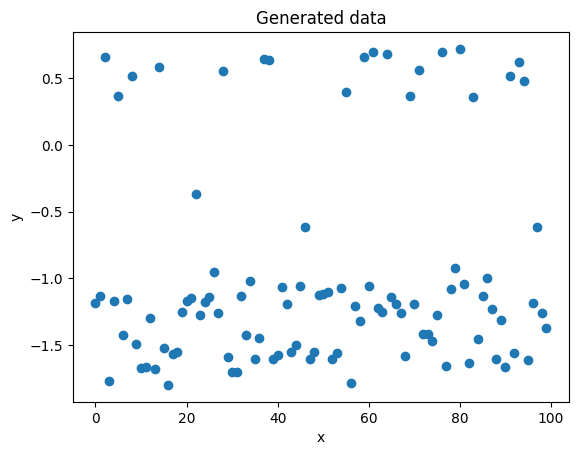

In [26]:
# Generate data
n = 100
alpha = 1
thetas = DP_sampler(n, alpha)
y = [f_sampler(theta) for theta in thetas]

# Plot data
plt.figure()
plt.scatter(np.arange(n), y)
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Algorithm 6

In [27]:
def algorithm_6_sample(theta, y, alpha):
    # Choose wether we sample from existing theta or from g0
    if np.random.rand() < alpha / (y.shape[0] + alpha):
        # Sample from g0
        theta = g0_sampler()
    else:
        # Sample from existing theta
        theta = np.random.choice(theta)

    return theta

def algorithm_6(N, y, alpha):
    n = y.shape[0]
    theta = np.zeros((N+1, n))
    for i in range(1, N+1):
        theta = thetas[i-1].copy()
        for j in range(n):
            theta[j] = algorithm_6_sample(theta, y[j], alpha)
        thetas[i] = theta.copy()

    return thetas


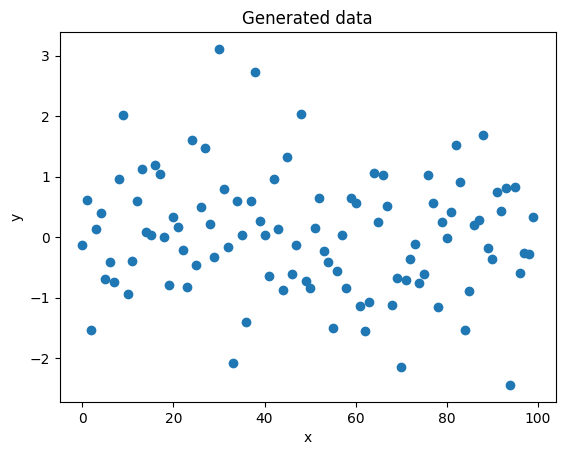

In [17]:
n = 100
N = 10000
alpha = 1
